**Valuing financial derivatives through Monte Carlo simulation is only possible using the financial mathematics of risk-neutral valuation and risk-neutral asset trajectory simulation..**

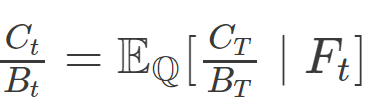

Note: This is the Risk-neutral Expectation Pricing Formula in Continuous Time

In [1]:
# Import dependencies
import math
import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import yfinance as yfin

# **What is Monte Carlo Simulation**

Purpose of Monte Carlo simulation: solve probability problems by numerically simulating many possible scenarios so that statistical properties of the outcome can be calculated, such as expectation, variance of probability of certain outcomes. In the case of financial derivatives, this gives us a tool for valuing complex derivatives that analytical formulas cannot do. It provides us with a simple way to deal with many random factors and combinations of more realistic asset price processes, such as asset price jumps.

# **Monte Carlo as a tool**

We can solve two types of financial problems: 

1. Portfolio Statistics (Brownian Motion represents true probabilities on the P-measure) 

- Expected profit Risk metrics (VaR, CVAR, ...) 

- Downside risk (Withdrawal figures, …) 

- other interest probabilities 

2. Valuation of derivatives with risk-neutral valuation (Brownian motion is a proxy for risk-neutral probability on the Q measure)

[*********************100%***********************]  6 of 6 completed


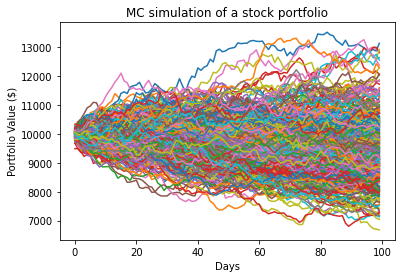

VaR_5 $2180.72
CVaR_5 $2602.35


In [2]:
# import data
yfin.pdr_override()

def get_data(stocks, start, end):
    stockData = pdr.get_data_yahoo(stocks, start, end)
    stockData = stockData['Close']
    returns = stockData.pct_change()
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    return meanReturns, covMatrix

stockList = ['CBA', 'BHP', 'TLS', 'NAB', 'WBC', 'STO']
stocks = [stock + '.AX' for stock in stockList]
endDate = datetime.datetime.now()
startDate = endDate - datetime.timedelta(days=300)
meanReturns, covMatrix = get_data(stocks, startDate, endDate)
weights = np.random.random(len(meanReturns))
weights /= np.sum(weights)
# Monte Carlo Method
mc_sims = 400 # number of simulations
T = 100 #timeframe in days
meanM = np.full(shape=(T, len(weights)), fill_value=meanReturns)
meanM = meanM.T
portfolio_sims = np.full(shape=(T, mc_sims), fill_value=0.0)
initialPortfolio = 10000
for m in range(0, mc_sims):
    Z = np.random.normal(size=(T, len(weights)))#uncorrelated RV's
    L = np.linalg.cholesky(covMatrix) #Cholesky decomposition to Lower Triangular Matrix
    dailyReturns = meanM + np.inner(L, Z) #Correlated daily returns for individual stocks
    portfolio_sims[:,m] = np.cumprod(np.inner(weights, dailyReturns.T)+1)*initialPortfolio
plt.plot(portfolio_sims)
plt.ylabel('Portfolio Value ($)')
plt.xlabel('Days')
plt.title('MC simulation of a stock portfolio')
plt.show()
def mcVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: percentile on return distribution to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        return np.percentile(returns, alpha)
    else:
        raise TypeError("Expected a pandas data series.")
def mcCVaR(returns, alpha=5):
    """ Input: pandas series of returns
        Output: CVaR or Expected Shortfall to a given confidence level alpha
    """
    if isinstance(returns, pd.Series):
        belowVaR = returns <= mcVaR(returns, alpha=alpha)
        return returns[belowVaR].mean()
    else:
        raise TypeError("Expected a pandas data series.")
        
        
portResults = pd.Series(portfolio_sims[-1,:])
VaR = initialPortfolio - mcVaR(portResults, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResults, alpha=5)
print('VaR_5 ${}'.format(round(VaR,2)))
print('CVaR_5 ${}'.format(round(CVaR,2)))

# **Computationally inefficient**

Compared to the simple analytical formulas available for certain PDEs such as the Black-Scholes option pricing model for European-style options, Monte Carlo is inefficient in its fundamental form. Of course, the reason we chose Monte Carlo is a method of valuing complex derivatives. Either way, we can improve the accuracy using: 

1) Method to reduce variance: 
- Antithetic Variates 
- Control Variates 

2) Quasi-random numbers (deterministic series) compared to pseudo random numbers.

# **Valuation by Simulation**

The risk-neutral pricing methodology tells us that: value of an option = risk-neutral expectation of its discounted payoff
We can estimate this expectation by computing the average of a large number of discounted payoffs. For a particular simulation i:

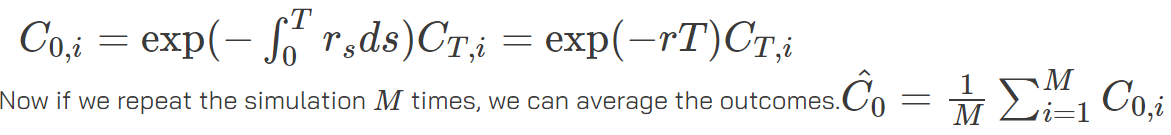

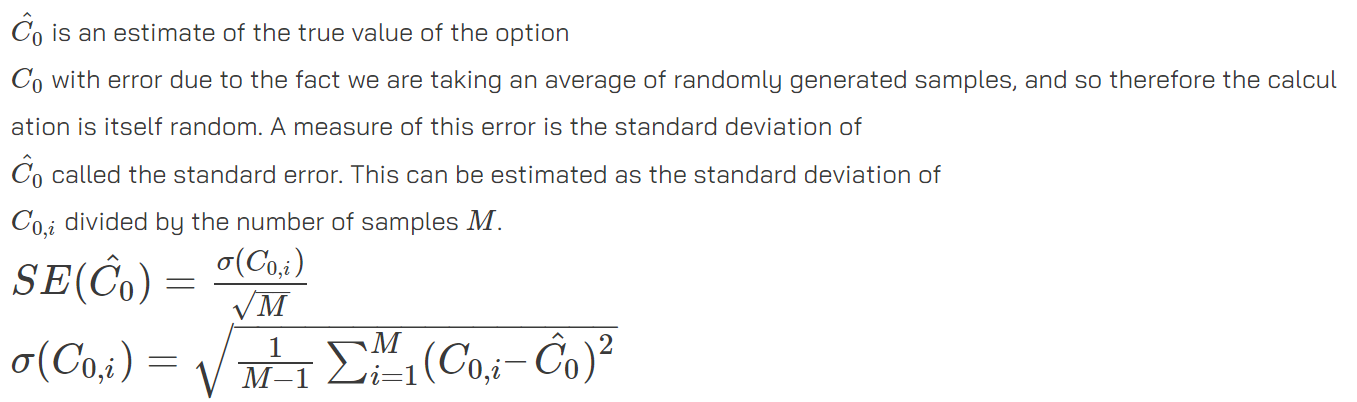

# **European Call Option in the Black-Scholes World**

Here we have constant interest rate so the discount factor is exp(−rT), and the stock dynamics are modelled with Geometric Brownian Motion (GBM).

dSt = rStdt+σStdWt

Let’s simulate this GBM process by simulating variables of the natural logarithm process of the stock price xt=ln(St), which is normally distributed. For the dynamics of the natural logarithm process of stock prices under GBM model we need to use Ito’s calculus.

dxt=νdt+σdzt,ν=r–σ^(2)/2

We can then discretize the Stochastic Differential Equation (SDE) by changing the infinitesimals dx,dt,dz into small steps Δx,Δt,Δz.

Δx=νΔt+σΔz

This is the exact solution to the SDE and involves no approximation.

xt+Δt=xt+ν(Δt)+σ(zt+Δt−zt)

In terms of the stock price S, we have:

St+Δt=Stexp(νΔt+σ(zt+Δt−zt))
Where (zt+Δt−zt)∼N(0,Δt)

In [3]:
# initial derivative parameters 
S = 101.15          #stock price
K = 98.01           #strike price
vol = 0.0991        #volatility (%)
r = 0.01            #risk-free rate (%)
N = 10              #number of time steps
M = 1000            #number of simulations
market_value = 3.86 #market price of option
T = ((datetime.date(2022,3,17)-datetime.date(2022,1,17)).days+1)/365    #time in years

# **Slow Solution – Steps**

In [4]:
# Precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Standard Error Placeholders
sum_CT = 0
sum_CT2 = 0
# Monte Carlo Method
for i in range(M):
    lnSt = lnS
    for j in range(N):
        lnSt = lnSt + nudt + volsdt*np.random.normal()
    
    ST = np.exp(lnSt)
    CT = max(0, ST - K)
    sum_CT = sum_CT + CT
    sum_CT2 = sum_CT2 + CT*CT
# Compute Expectation and SE
C0 = np.exp(-r*T)*sum_CT/M
sigma = np.sqrt( (sum_CT2 - sum_CT*sum_CT/M)*np.exp(-2*r*T) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.65 with SE +/- 0.11


# **Fast Solution – Vectorized**

In [5]:
#precompute constants
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.69 with SE +/- 0.11


# **Only 1 Step is Necessary in this example!**

For simple processes where the SDE does not need to be approximated like in the case of Geometric Brownian Motion used for calculating a European Option Price, we can just simulate the variables at the final Time Step as Brownian Motion scales with time and independent increments.

In [6]:
#precompute constants
N = 1
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)
# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_lnSt = nudt + volsdt*Z 
lnSt = lnS + np.cumsum(delta_lnSt, axis=0)
lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) )
# Compute Expectation and SE
ST = np.exp(lnSt)
CT = np.maximum(0, ST - K)
C0 = np.exp(-r*T)*np.sum(CT[-1])/M
sigma = np.sqrt( np.sum( (CT[-1] - C0)**2) / (M-1) )
SE = sigma/np.sqrt(M)
print("Call value is ${0} with SE +/- {1}".format(np.round(C0,2),np.round(SE,2)))

Call value is $3.72 with SE +/- 0.11


# **Visualisation of Convergence**

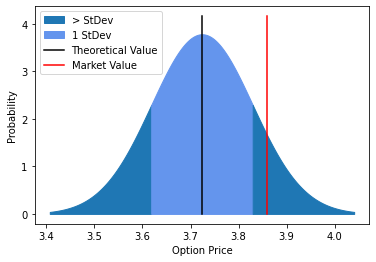

In [7]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot([C0,C0],[0, max(s2)*1.1], 'k', label='Theoretical Value')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r', label='Market Value')
plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()